In [32]:
from bs4 import BeautifulSoup
import requests

import string 
import re

import scipy.sparse
from nltk import word_tokenize, pos_tag
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use("seaborn")
%matplotlib inline

from mcu_functions import lemmatizer_tokenizer, verb_adj, get_script, get_script2, get_script3
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Scrape the scripts 

In [2]:
mult_table = ['Captain_Marvel_(2019)','Captain_America:_The_First_Avenger', 'Ant-Man',
              'Iron_Man', 'Iron_Man_2', 'Spider-Man:_Homecoming', 'Iron_Man_3', 
             'Thor:_The_Dark_World', 'Captain_America:_The_Winter_Soldier', 'Avengers:_Age_of_Ultron',
              'Captain_America:_Civil_War', 'Avengers:_Infinity_War', 'Avengers:_Endgame']

In [3]:
mult_table2 = ['Doctor Strange', 'Avengers', 'Black Panther']

In [4]:
m3 = mult_table + mult_table2

In [5]:
transcript2 = []

for linked in mult_table:
    transcript2.append(get_script(linked))

In [6]:
#get black panther script from imsdb
url = 'https://www.imsdb.com/scripts/Black-Panther.html'

response = requests.get(url).text
soup = BeautifulSoup(response, "lxml")

script = soup.find(class_='scrtext').find_all('b')
script2 = [row.next_sibling for row in script]

scrib = [' '.join(str(v) for v in script2)]

In [7]:
transcript3 = transcript2 + get_script2('Doctor_Strange') + get_script3('The_Avengers') + scrib

### Put scripts into a dataframe

In [8]:
df = pd.DataFrame(transcript3, index = m3, columns=['script'])
df

,script
Captain_Marvel_(2019),\n \n <i>[annoyed and tired]</i> Do you know ...
Captain_America:_The_First_Avenger,\n \n \n \n : Are you the guys from Washington...
Ant-Man,\n \n : Stark.\n : He doesn’t seem happy.\n : ...
Iron_Man,None <br/> \n \n I feel like you're driving m...
Iron_Man_2,\n \n None Been a while since I was up here i...
Spider-Man:_Homecoming,\n \n : Things are never gonna be the same now...
Iron_Man_3,\n \n None : We create our own demons. Who sai...
Thor:_The_Dark_World,\n \n : [ Such evil was possible through the p...
Captain_America:_The_Winter_Soldier,\n \n \n \n : On your left.\n : On your left.\...
Avengers:_Age_of_Ultron,"\n \n None : [ : Shit!\n : Language! JARVIS, w..."


#### Pickle Dataframe

In [9]:
remove_i = lambda x:re.sub("\n", '', x)
remove_c = lambda x:re.sub("<[^>]*> ", '', x)
remove_d = lambda x:re.sub("<i>", '', x)
remove_x = lambda x:re.sub("\r", '', x)
df['script'] = df.script.map(remove_c).map(remove_i).map(remove_d)

In [10]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['script'] = df.script.map(alphanumeric).map(punc_lower)

In [11]:
data = pd.DataFrame(df.script.apply(lemmatizer_tokenizer))
data

,script
Captain_Marvel_(2019),annoyed and tired do you know what time it is ...
Captain_America:_The_First_Avenger,are you the guy from washington you get many o...
Ant-Man,stark he doesn t seem happy hello hank you re ...
Iron_Man,none i feel like you re driving me to a court ...
Iron_Man_2,none been a while since i wa up here in front ...
Spider-Man:_Homecoming,thing are never gonna be the same now i mean l...
Iron_Man_3,none we create our own demon who said that wha...
Thor:_The_Dark_World,such evil wa possible through the power of the...
Captain_America:_The_Winter_Soldier,on your left on your left uh huh on my left go...
Avengers:_Age_of_Ultron,none shit language jarvis what s the view from...


In [12]:
data2 = pd.DataFrame(data.script.apply(verb_adj))
data2

,script
Captain_Marvel_(2019),wan i new t vulnerable supreme dangerous warri...
Captain_America:_The_First_Avenger,many other russian come i long i t open long g...
Ant-Man,t happy poor revolutionary u good i such god e...
Iron_Man,crazy hey forrest sir s personal good i i i i ...
Iron_Man_2,i i u bodyguard mysterious undisclosed high of...
Spider-Man:_Homecoming,same mean alien big green indian s native amer...
Iron_Man_3,own doesn famous uh sigh let tony great i piti...
Thor:_The_Dark_World,such evil possible ancient infinite noble migh...
Captain_America:_The_Winter_Soldier,left uh left left new late whole good soft i m...
Avengers:_Age_of_Ultron,central other hydra loki s last long last litt...


In [13]:
data2.to_pickle('project4.pkl')

### Sentiment Analysis with Textblob

In [14]:
sentiment = data.copy()

In [15]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

sentiment['polarity'] = sentiment['script'].apply(pol)
sentiment['subjectivity'] = sentiment['script'].apply(sub)
sentiment

,script,polarity,subjectivity
Captain_Marvel_(2019),annoyed and tired do you know what time it is ...,0.067583,0.430138
Captain_America:_The_First_Avenger,are you the guy from washington you get many o...,0.071934,0.454701
Ant-Man,stark he doesn t seem happy hello hank you re ...,0.075648,0.488355
Iron_Man,none i feel like you re driving me to a court ...,0.125319,0.508837
Iron_Man_2,none been a while since i wa up here in front ...,0.116429,0.503312
Spider-Man:_Homecoming,thing are never gonna be the same now i mean l...,0.088414,0.508186
Iron_Man_3,none we create our own demon who said that wha...,0.126836,0.515926
Thor:_The_Dark_World,such evil wa possible through the power of the...,0.077638,0.475262
Captain_America:_The_Winter_Soldier,on your left on your left uh huh on my left go...,0.059985,0.445079
Avengers:_Age_of_Ultron,none shit language jarvis what s the view from...,0.041603,0.487641


In [16]:
year = [2019, 2011, 2015, 2008, 2010, 2017, 2013, 2013, 2014, 2015, 2016, 2018, 2019, 2016, 2012, 2018]

In [17]:
sentiment['year'] = year

In [18]:
sentiment

,script,polarity,subjectivity,year
Captain_Marvel_(2019),annoyed and tired do you know what time it is ...,0.067583,0.430138,2019
Captain_America:_The_First_Avenger,are you the guy from washington you get many o...,0.071934,0.454701,2011
Ant-Man,stark he doesn t seem happy hello hank you re ...,0.075648,0.488355,2015
Iron_Man,none i feel like you re driving me to a court ...,0.125319,0.508837,2008
Iron_Man_2,none been a while since i wa up here in front ...,0.116429,0.503312,2010
Spider-Man:_Homecoming,thing are never gonna be the same now i mean l...,0.088414,0.508186,2017
Iron_Man_3,none we create our own demon who said that wha...,0.126836,0.515926,2013
Thor:_The_Dark_World,such evil wa possible through the power of the...,0.077638,0.475262,2013
Captain_America:_The_Winter_Soldier,on your left on your left uh huh on my left go...,0.059985,0.445079,2014
Avengers:_Age_of_Ultron,none shit language jarvis what s the view from...,0.041603,0.487641,2015


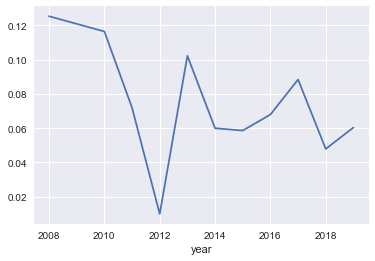

In [23]:
sentiment.groupby('year').polarity.mean().plot()

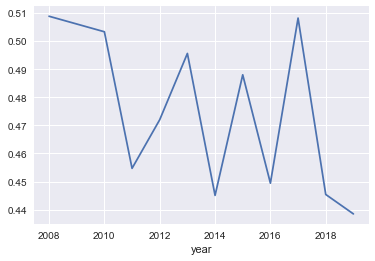

In [24]:
sentiment.groupby('year').subjectivity.mean().plot()

### Sentiment Analysis with Vader

In [26]:
analyser = SentimentIntensityAnalyzer()

In [27]:
sentiment['polarity2'] = sentiment['script'].apply(lambda review: analyser.polarity_scores(review))

In [28]:
sentiment['compound']  = sentiment['polarity2'].apply(lambda score_dict: score_dict['compound'])

In [29]:
sentiment

,script,polarity,subjectivity,year,polarity2,compound
Captain_Marvel_(2019),annoyed and tired do you know what time it is ...,0.067583,0.430138,2019,"{'neg': 0.122, 'neu': 0.771, 'pos': 0.107, 'co...",-0.9999
Captain_America:_The_First_Avenger,are you the guy from washington you get many o...,0.071934,0.454701,2011,"{'neg': 0.1, 'neu': 0.78, 'pos': 0.12, 'compou...",0.9997
Ant-Man,stark he doesn t seem happy hello hank you re ...,0.075648,0.488355,2015,"{'neg': 0.098, 'neu': 0.747, 'pos': 0.155, 'co...",1.0000
Iron_Man,none i feel like you re driving me to a court ...,0.125319,0.508837,2008,"{'neg': 0.083, 'neu': 0.767, 'pos': 0.15, 'com...",1.0000
Iron_Man_2,none been a while since i wa up here in front ...,0.116429,0.503312,2010,"{'neg': 0.073, 'neu': 0.764, 'pos': 0.164, 'co...",1.0000
Spider-Man:_Homecoming,thing are never gonna be the same now i mean l...,0.088414,0.508186,2017,"{'neg': 0.104, 'neu': 0.761, 'pos': 0.135, 'co...",1.0000
Iron_Man_3,none we create our own demon who said that wha...,0.126836,0.515926,2013,"{'neg': 0.097, 'neu': 0.758, 'pos': 0.146, 'co...",1.0000
Thor:_The_Dark_World,such evil wa possible through the power of the...,0.077638,0.475262,2013,"{'neg': 0.116, 'neu': 0.755, 'pos': 0.129, 'co...",0.9995
Captain_America:_The_Winter_Soldier,on your left on your left uh huh on my left go...,0.059985,0.445079,2014,"{'neg': 0.134, 'neu': 0.771, 'pos': 0.095, 'co...",-1.0000
Avengers:_Age_of_Ultron,none shit language jarvis what s the view from...,0.041603,0.487641,2015,"{'neg': 0.105, 'neu': 0.764, 'pos': 0.131, 'co...",0.9999


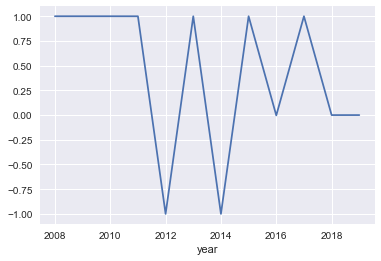

In [30]:
sentiment.groupby('year').compound.mean().plot()